In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score

import scikitplot as skplt

2024-07-16 21:30:06.133396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 21:30:06.967253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [3]:
X_train = df_train.drop(['satisfaction'], axis=1).values
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1).values
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1).values
y_test = df_test['satisfaction'].values

##### Declarando as funções de metricas

In [4]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [5]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [7]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Criando o modelo MLP

In [8]:
model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(50, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(2, activation='softmax')
])

2024-07-16 21:30:13.502563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-16 21:30:13.502975: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
model.compile(
    optimizer=Adam(), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    min_delta=0.001,
    restore_best_weights=True
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852 (7.23 KB)

 Trainable params: 1,852 (7.23 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train,
    y_train, 
    epochs=15, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 868us/step - accuracy: 0.8347 - loss: 0.3916 - val_accuracy: 0.9014 - val_loss: 0.2517
Epoch 2/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9033 - loss: 0.2445 - val_accuracy: 0.9242 - val_loss: 0.1926
Epoch 3/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9186 - loss: 0.2034 - val_accuracy: 0.9310 - val_loss: 0.1734
Epoch 4/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9232 - loss: 0.1835 - val_accuracy: 0.9356 - val_loss: 0.1578
Epoch 5/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9262 - loss: 0.1774 - val_accuracy: 0.9388 - val_loss: 0.1549
Epoch 6/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - accuracy: 0.9305 - loss: 0.1672 - val_accuracy: 0.9407 - val_loss: 0.1469
Epoch 7/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9360 - loss: 0.1584 - val_accuracy: 0.9437 - val_loss: 0.1380
Epoch 8/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9371 - loss: 0.152

##### Avaliando o modelo

In [13]:
mlp_pred_scores = model.predict(X_test)
mlp_pred_class = np.argmax(mlp_pred_scores, axis=1)

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step


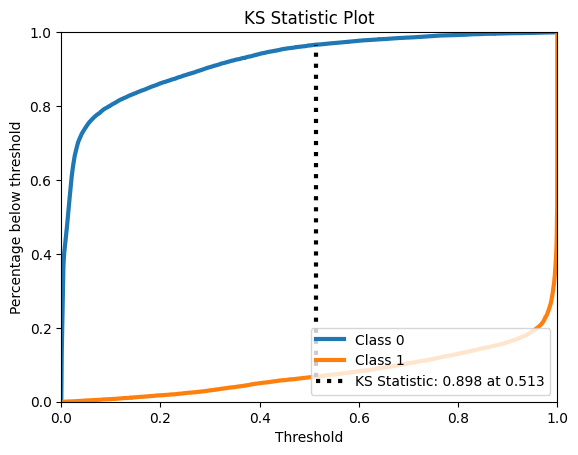



Multi Layer Perceptron - Test

Accuracy:         0.9509
Recall:           0.9341
Precision:        0.9520
F1:               0.9430
AUROC:            0.9910
AUPR:             0.9895


In [14]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('\n\nMulti Layer Perceptron - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

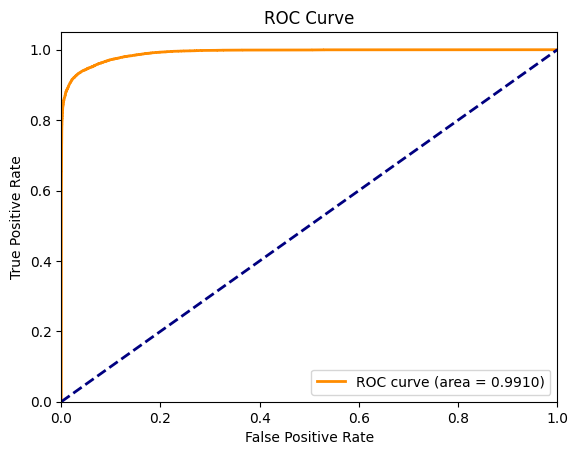

In [16]:
plot_roc_curve(mlp_pred_scores, y_test)

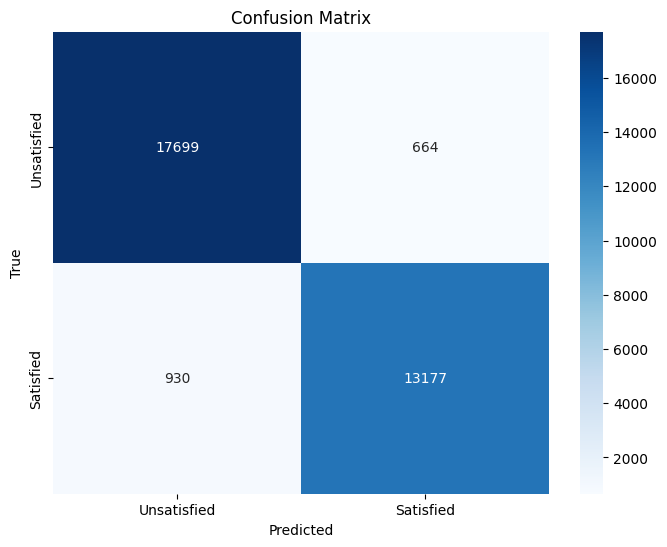

In [15]:
plot_confusion_matrix(y_pred=mlp_pred_class, y_test=y_test)